# This is a Colab Notebook for Summarization of Reddit-TIFU dataset using PEGASUS

In [ ]:
!pip3 install transformers

In [ ]:
!pip3 install sentencepiece

In [ ]:
from transformers import AutoModelWithLMHead, AutoTokenizer, AutoModelForSeq2SeqLM

In [ ]:
model_name = 'google/pegasus-large'

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
ARTICLE= """Picture this: a herd of elephants flies past you at sixty miles per hour, followed by a streak of tigers, a pride of lions, and a bunch of clowns. 
What do you see? It must be a circus train! One of the first uses of the circus train is credited to W.C. Coup. He 
partnered with P.T. Barnum in 1871 to expand the reach of their newly combined shows using 
locomotives. Before circus trains, these operators had to lug around all of their animals, 
performers, and equipment with a team of more than 600 horses. Since there were no highways, 
these voyages were rough and took a long time. Circuses would stop at many small towns 
between the large venues. Performing at many of these small towns was not very profitable. 
Because of these limitations, circuses could not grow as large as the imaginations of the 
operators. After they began using circus trains, Barnum and Coup only brought their show to 
large cities. These performances were much more profitable and the profits went toward creating 
an even bigger and better circus. Multiple rings were added and the show went on. Today, 
Ringling Bros. and Barnum and Bailey Circus still rely on the circus train to transport their 
astounding show, but now they use two."""
inputs = tokenizer.encode("summarize: " + ARTICLE, return_tensors="pt", truncation=True, max_length=512)
outputs = model.generate(inputs, max_length=150, min_length=40, num_beams=4, length_penalty=2.0, early_stopping=True)
print("Your summary: ")
print(tokenizer.decode(outputs[0]))

Your summary: 
<pad> used the circus train to transport their show to large cities. made their show bigger and better. still use the circus train to transport their show to large cities. still use the circus train to transport their show to large cities.</s>


In [ ]:
!pip install ohmeow-blurr -q
!pip install datasets -q

In [ ]:
!pip install bert-score -q

In [ ]:
import datasets
import pandas as pd
import seaborn as sns
from fastai.text.all import *
from transformers import *

from blurr.data.all import *
from blurr.modeling.all import *

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# using a subset of the training set to build both training and validation DataLoaders; https://huggingface.co/docs/datasets/splits.html

raw_data = datasets.load_dataset('reddit_tifu','long',split='train[:100%]')

Reusing dataset reddit_tifu (/root/.cache/huggingface/datasets/reddit_tifu/long/1.1.0/c383d53c57bebbb2972419fc23c3f58639c7f9074004ef1c49c1c0bcfa2218a3)


In [ ]:
#showing an example of dataset
df = pd.DataFrame(raw_data)
df.head(5)

,documents,num_comments,score,title,tldr,ups,upvote_ratio
0,"this actually happened a couple of years ago. i grew up in germany where i went to a german secondary school that went from 5th to 13th grade (we still had 13 grades then, they have since changed that). my school was named after anne frank and we had a club that i was very active in from 9th grade on, which was dedicated to teaching incoming 5th graders about anne franks life, discrimination, anti-semitism, hitler, the third reich and that whole spiel. basically a day where the students' classes are cancelled and instead we give them an interactive history and social studies class with lot...",23.0,115.0,gender-stereotyping,confuse a 5th grade girl for a boy in front of half of her class. kids are mean. sorry sandra.**,115.0,0.88
1,"it was last october, but i'm feeling the fall-out from it the most today. \n\nafter my mom died from cancer last year, i started looking for my estranged father. i had only known him for a short time when i was 6 and barely remembered more than his name. i never knew why he left and my mom would not talk about him without obvious emotional pain, so i didn't push her for information about him. i figured he didn't care about us.\n\ni had googled him multiple times over the years, but he was always unlisted and i didn't have an address with which to search. after her death, i felt strong...",12.0,16.0,telling my dad that i love him.,"i found my estranged dad, thought i loved him after getting to know him, got to know him better and changed my mind.",16.0,0.79
2,"so i had the brilliant idea to use veet hair removal gel as the ol' danglies were in need of a trim and i had heard that veet leaves them smoother for longer. well i guess thats right when the skin has to grow back first. \n\npre-story: i tried this before and the results were great but i had decided to do it again because of how well it worked. \n\nso i take out the gel/cream stuff and just lob it on and cover the forest. the slight peroxide kinda smell ensued and all was going well, there was a slight burning but thats to be expected, you know, melting pubes off does that. so comes the a...",10.0,55.0,i was deveeted...,had my balls burned by sauron and was left deveeted.,55.0,0.85
3,"today i was going to have a bath after a long day of painting kids faces at a carnival. all would go well, except being the genius i am, i put in some epsom salts (i always do for my bath), and i grabbed my bottle of peppermint essential oil.\n\n lately, i've been on a diy-pinterest-tumblr-let's-make-my-own-shit-and-be-fancy spree. the other day i took a 'detox bath' (fyi did nothing for me guys. uselessss). so, my brain totally went 'hey, trajectorys, put some peppermint in! it's good for your skin!' okay brain!\n\nso, instead of logically putting in like... 5 drops so it's nice and minty...",20.0,90.0,wanting a pepperminty bath.,peppermint + bath = burning cold ladybits.,90.0,0.92
4,"i haven't had a bath in practically years so, after finally moving into a house with a bath, i decide to have one. having recently purchased a shiny new bag of weed, i thought combining the two would be a good idea.\n\npicture this; a very cramped bathroom, no windows, a shitty extractor fan, closed door, steaming hot bath and a spliff. as i lay there gently swishing to and fro, giggling like a little school girl, i neglected to notice how hot the room was becoming. \n\nafter a while i looked up and realised i could barely even see the taps in front of me. naturally, i begin to panic and s...",18.0,81.0,having a spliff in the bath.,"got too high and too hot in the bath, almost cooked myself like a lobster.",81.0,0.79


In [ ]:
#removing special characters from the summaries in the dataset.
df.tldr = df.tldr.str.replace('[#,@,&,!,$,%,^,&,*]', '')

In [ ]:
#dataset dimensions before preprocessing.
print("our data set has {} rows and {} columns".format(df.shape[0],df.shape[1]))
print("The {} feature is our target feature and we are summarizing text from {} column.".format(df.columns[4],df.columns[0]))
#raw_data.shape

our data set has 4214 rows and 7 columns
The tldr feature is our target feature and we are summarizing text from documents column.


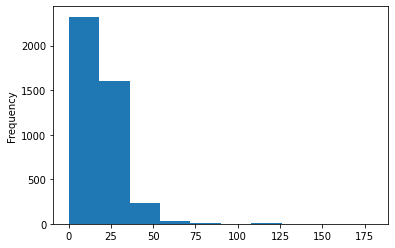

In [ ]:
df['totalwords'] = df['tldr'].str.split().str.len()
df["totalwords"].plot(kind="hist")

In [ ]:
print("The longest sentence in the summaries have {} words.".format(df.totalwords.max()))

The longest sentence in the summaries have 180 words.


Text(0, 0.5, 'number of summarized sentences')

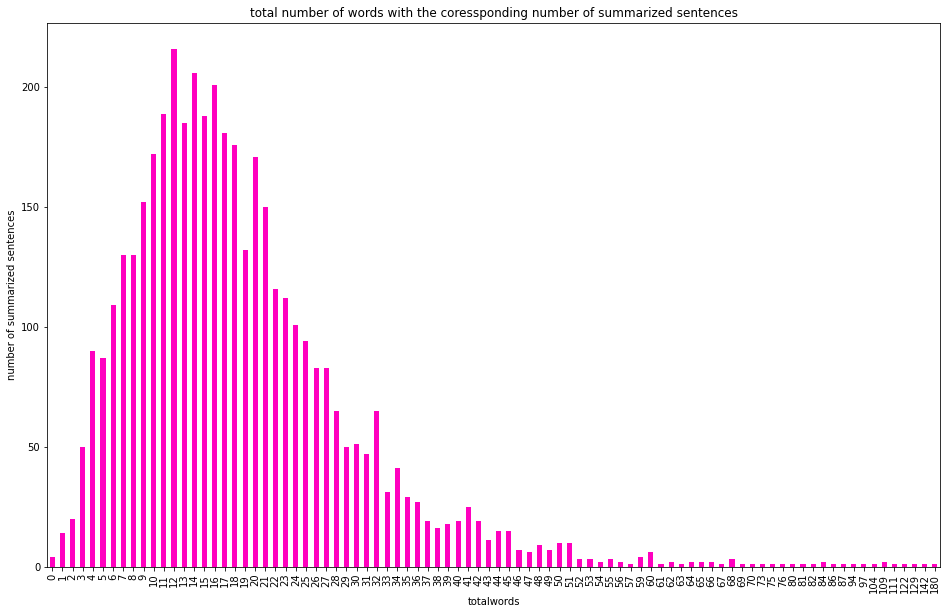

In [ ]:
#bar plot showing the total number of words with the coressponding number of summarized sentences.
grouping =df.groupby("totalwords")
y = grouping.tldr.count()
yplt =y.plot(kind="bar",figsize=(16,10),colormap="gist_rainbow_r",title="total number of words with the coressponding number of summarized sentences")
yplt.set_ylabel("number of summarized sentences")

In [ ]:
#filter the dataset with target features having total words less than 31 
df = df[df.tldr.str.split().str.len() < 25]

In [ ]:
#filter the dataset with target features having total words more than 21
df = df[df.tldr.str.split().str.len() > 16]

Text(0, 0.5, 'number of summarized sentences')

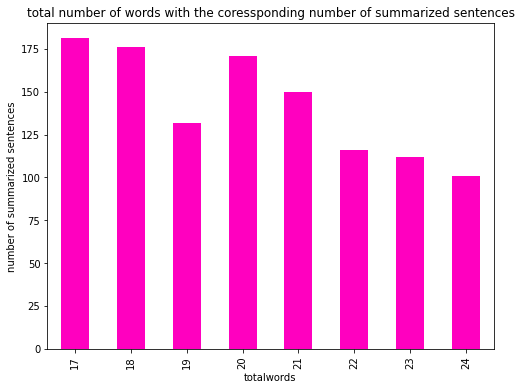

In [ ]:
#bar plot showing the total number of words with the coressponding number of summarized sentences after removing outliers.
grouping =df.groupby("totalwords")
y = grouping.tldr.count()
yplt =y.plot(kind="bar",figsize=(8,6),colormap="gist_rainbow_r",title="total number of words with the coressponding number of summarized sentences")
yplt.set_ylabel("number of summarized sentences")

In [ ]:
print("our data set now has {} rows and {} columns after removing outliers.".format(df.shape[0],df.shape[1]))

our data set now has 1139 rows and 8 columns after removing outliers.


In [ ]:
#example of a given summary
print("Summarization example: \n{}".format(df['tldr'].iloc[2]))

Summarization example: 
tried to microwave french fries and stuck my finger into a franken-fuck of pain causing first degree burns


In [ ]:
#checking if our target feature having any empty strings
list(df[df['tldr'] == ''].index)

[]

In [ ]:
df['tldr']

0                           confuse a 5th grade girl for a boy in front of half of her class. kids are mean. sorry sandra.
1       i found my estranged dad thought i loved him after getting to know him got to know him better and changed my mind.
6               tried to microwave french fries and stuck my finger into a franken-fuck of pain causing first degree burns
10                    lost my virginity on someones driveway with a girl i didn't give a shit about and peed in her mouth.
12                                       i told my sister i came on my mother last night because of a song she was singing
                                                               ...                                                        
4200              tried pranking my friends by turning up the heat in the sauna to wake them up to the heat. it backfired.
4201          i laughed at a porn joke that i shouldn't have gotten without reference and got strange looks from my class.
4205            

In [ ]:
#df["totalwords"].mean()
#df["number_of_words"].max() 
print("The minmum number of words in a summary is {}".format(df["totalwords"].min()))
print("The maximum number of words in a summary is {}".format(df["totalwords"].max()))
print("The avarege number of words in a summary is {}".format(df["totalwords"].mean()))

The minmum number of words in a summary is 17
The maximum number of words in a summary is 24
The avarege number of words in a summary is 20.08340649692713


In [ ]:
#getting the required objects (the architecture, tokenizer, config, and model, using get_hf_objects helper method
pretrained_model_name = "google/pegasus-large"
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, 
                                                                               model_cls=PegasusForConditionalGeneration)

hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

('pegasus',
 transformers.models.pegasus.configuration_pegasus.PegasusConfig,
 transformers.models.pegasus.tokenization_pegasus_fast.PegasusTokenizerFast,
 transformers.models.pegasus.modeling_pegasus.PegasusForConditionalGeneration)

In [ ]:
#parameters dict generation with the default values 
text_gen_kwargs = default_text_gen_kwargs(hf_config, hf_model, task='summarization')
text_gen_kwargs

{'bad_words_ids': None,
 'bos_token_id': 0,
 'decoder_start_token_id': 0,
 'diversity_penalty': 0.0,
 'do_sample': False,
 'early_stopping': False,
 'encoder_no_repeat_ngram_size': 0,
 'eos_token_id': 1,
 'length_penalty': 0.6,
 'max_length': 128,
 'min_length': 32,
 'no_repeat_ngram_size': 0,
 'num_beam_groups': 1,
 'num_beams': 8,
 'num_return_sequences': 1,
 'output_attentions': False,
 'output_hidden_states': False,
 'output_scores': False,
 'pad_token_id': 0,
 'repetition_penalty': 1.0,
 'return_dict_in_generate': False,
 'temperature': 1.0,
 'top_k': 50,
 'top_p': 1.0,
 'use_cache': True}

In [ ]:
#customizing the text generation by changing values in text_gen_kwargs
hf_batch_tfm = HF_Seq2SeqBeforeBatchTransform(hf_arch, hf_config, hf_tokenizer, hf_model, 
                                              max_length=256, max_tgt_length=128, text_gen_kwargs= 
{'bad_words_ids': None,
 'bos_token_id': 0,
 'decoder_start_token_id': 0,

 'diversity_penalty': 0.0,
 'do_sample': False,
 'early_stopping': True,
 'eos_token_id': 1,
 'length_penalty': 0.6,
 'max_length': 128,
 'min_length': 32,
 'no_repeat_ngram_size': 0,
 'num_beam_groups': 1,
 'num_beams': 8,
 'num_return_sequences': 1,
 'output_attentions': False,
 'output_hidden_states': False,
 'output_scores': False,
 'pad_token_id': 0,
 'repetition_penalty': 1.0,
 'return_dict_in_generate': False,
 'temperature': 1.0,
 'top_k': 50,
 'top_p': 1.0,
 'use_cache': True})

blocks = (HF_Seq2SeqBlock(before_batch_tfm=hf_batch_tfm), noop)
#change article to document and change highlights to sumamry
dblock = DataBlock(blocks=blocks, get_x=ColReader('documents'), get_y=ColReader('tldr'), splitter=RandomSplitter())




In [ ]:
dls = dblock.dataloaders(df, bs=2)

In [ ]:
len(dls.train.items), len(dls.valid.items)

(912, 227)

In [ ]:
#batch shape
b = dls.one_batch()
len(b), b[0]['input_ids'].shape, b[1].shape

(2, torch.Size([2, 256]), torch.Size([2, 33]))

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2)

,text,target
0,"preface: a bit of a read, but well worth it if you have the time. i pray that this fate never befalls any of you. edit: ""eight-pumped"" is a term i made up to describe a sexual act consisting of a mere eight strokes. sorry about any potential confusion. the horrible misadventures of thedoctorg20 and gatsby: part one so everything was pretty normal today, just hanging out after attending my first class and waiting for my next to start at 4. as i sat there in my siberian husky boxers (every man should own a pair) and contemplated life while watching nicholas snooze the day away (he is an adorable sleeper, you're not the police of me) my phone vibrates and i peer over my shoulder to see who it was. [name withheld] had texted me! we had been talking for a couple of days and the night previous i had convinced her to send me some racy pictures so she obviously found it troublesome to contain the sexual beast that i had unleashed inside of her. she wanted to visit me and i could naught but oblige.... i'll take this moment to explain my genitalia. i named it gatsby for the purpose of this",i eight-pumped a horny co-ed to shut her up she bursts into tears and then apologizes for it. the ass was fat.
1,"so, yeah... this is a throw away and my first post to tifu. this happened... well, has been happening since yesterday. tifu by telling my brothers crazy girlfriend she was full of shit and abusing my brother, so she went to the police. now i can't contact my brother. background: i'm a medical professional and am well respected in my community. i live in one city a few hundred miles away from my home town. the girlfriend and i were visiting home for christmas when my father expressed concern to me about my brothers living situation. my brother has autism and he's just a year or so younger than me, but he's never done well for himself like i have. he hooked up with this insane chick about 3 years ago and we've done our best to be warm and welcome her and her schizophrenic 8 year old into our collective family. she's got a long history of being a pathological liar and manipulator. she's a classy broad. my brother and her were going to get married, until they realized it would cut their welfare, so they had a ""spiritual wedding"" without any legal changes. recently it has become clear this is an abusive relationship and she's taking advantage of my brother and using",i did my best and it wasn't perfect or graceful. thanks to everyone who was kind and understanding during this very difficult time.


In [ ]:
seq2seq_metrics = {
        'rouge': {
            'compute_kwargs': { 'rouge_types': ["rouge1", "rouge2", "rougeL"], 'use_stemmer': True },
            'returns': ["rouge1", "rouge2", "rougeL"]
       
        }
    }

In [ ]:
model = HF_BaseModelWrapper(hf_model)
learn_cbs = [HF_BaseModelCallback]
fit_cbs = [HF_Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics)]

learn = Learner(dls, 
                model,
                opt_func=ranger,
                loss_func=CrossEntropyLossFlat(),
                cbs=learn_cbs,
                splitter=partial(seq2seq_splitter, arch=hf_arch)).to_fp16()

learn.create_opt() 
learn.freeze()

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=0.05754399299621582)

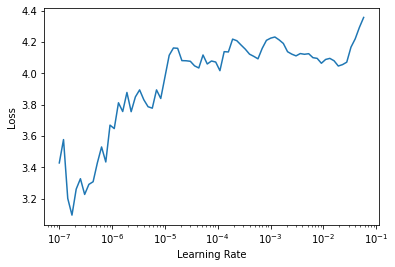

In [ ]:
learn.lr_find(suggestions=True)

In [ ]:
#running a batch to the model and output the shape
b = dls.one_batch()
preds = learn.model(b[0])
len(preds),preds[0], preds[1].shape

(4,
 tensor(4.7215, device='cuda:0', grad_fn=<NllLossBackward>),
 torch.Size([2, 33, 96103]))

In [ ]:
learn.fit_one_cycle(100, lr_max=3e-6, cbs=fit_cbs)

epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,time
0,4.063241,3.416752,0.298589,0.097162,0.233383,04:28
1,4.142364,3.413149,0.301218,0.098430,0.234302,04:27
2,4.053259,3.408268,0.300892,0.097921,0.233647,04:27
3,3.829975,3.402395,0.299959,0.098445,0.233173,04:26
4,3.962627,3.394458,0.301285,0.096945,0.234147,04:28
5,4.087235,3.385058,0.303886,0.098994,0.237349,04:29
6,3.862992,3.374081,0.303648,0.099277,0.236040,04:30
7,3.915909,3.361834,0.302259,0.099239,0.236594,04:32
8,3.923402,3.348493,0.299835,0.097145,0.236561,04:31
9,3.704533,3.333591,0.304139,0.101385,0.238787,04:33


In [ ]:
learn.show_results(learner=learn, max_n=2)

,text,target,prediction
0,"hi, i'm x-posting this here because i'm not sure where else to go with it, this is a big sub and if it's ever going to gain momentum i think this is the place to do it, i haven't quite fucked up yet but i could well be heading towards disaster with this, the woman in question in the following text is pure evil and not to be messed with. at the moment it's harmless but i'm pretty sure that will change tonight. mmmkay, reddit, this is my first throwaway post here and this is the most recent, relevant post i can find given that there is no sub for catfish this is happening now and it started yesterday. i'm a young, fairly good looking male, i recently became single and have been dating online, yesterday i had a friend request from an exceptionally hot girl (already questionable, i don't get many of those) my profile is private so i know she must have typed my name in to find me so i sent a message before accepting her request to try figure out if it was my ex girlfriend trying to troll somehow. after an hour or so of friendly chat with this stranger which was harmless enough, i was pretty well convinced she was not",; my friends ex is trying to catfish me but i know its her and she doesn't know i know it's her.,i accepted a friend request from an extremely hot girl thinking it was my ex girlfriend trying to troll me. turns out it was just a random stranger trying to find me.
1,"first off, sorry for the wall of text. we were out all afternoon, visiting my inlaws. it was a good day, we raided their basement for party supplies and had pasties for lunch. for the uninformed, a pasty is a bready pocket of deliciousness filled with meat and vegetables. like i said, delicious, but sort of a gut bomb. it was an hour drive home and by the time we pulled into the driveway i could feel some serious business brewing. i run in the door and made for the downstairs bathroom. as i enter, i peripherally note a kind of ""gloop-gloop"" coming from somewhere in the wall. in my haste to sink the bismarck, i ignore this and start doing my thing. ahhh, sweet relief. i read a few pages of my book, then finish up and flush. as i'm leaving the bathroom, i hear that gloop-gloop again, and then a steady whoosh. suddenly my toilet is a swirling maelstrom of brown, and it's up and over the rim before i can say, ""oh, shee-"". i yell to the wife, ""fuck, the toilet's overflowing!"" god love her, she springs into",delicious pocket snack inadvertently triggers a tsunami of shit that wrecks up our house wife and i clean up with comically ineffectual tools.,ate a ton of pasty's and shit all over the floor of my inlaws house. toilet overflowed and i screamed at my wife.
